Notebook for analyse the avaiable data for training, test and validation

dataset: https://huggingface.co/datasets/fpaulino/portuguese-tweets

In [26]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import textstat
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [ ]:
# Load data

splits = {'train': 'data/train-00000-of-00001.parquet', 
          'validation': 'data/validation-00000-of-00001.parquet', 
          'test': 'data/test-00000-of-00001.parquet'}

train_data = pd.read_parquet("hf://datasets/fpaulino/portuguese-tweets/" + splits["train"])
test_data = pd.read_parquet("hf://datasets/fpaulino/portuguese-tweets/" + splits["test"])
validation_data = pd.read_parquet("hf://datasets/fpaulino/portuguese-tweets/" + splits["validation"])

First rows of each df

In [17]:
train_data.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [18]:
test_data.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [19]:
validation_data.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1036508420160061440,A segunda é morta em qualquer lugar kkk #Fato 😂😴,Mon Sep 03 06:57:19 +0000 2018,2,#fato
1,1036503115946749954,TERRORISMO DA ESQUERDA COMUNISTA NO RIO DE JAN...,Mon Sep 03 06:36:14 +0000 2018,2,#fato
2,1036477508076617728,Confrontos na Alemanha entre grupos contra e p...,Mon Sep 03 04:54:29 +0000 2018,2,#noticia
3,1036476764686561280,"Ninguém é tão feio como na identidade, bonito ...",Mon Sep 03 04:51:32 +0000 2018,2,#fato
4,1036454709425520640,#Repost @renascerpraise ・・・ #novidade Estamos ...,Mon Sep 03 03:23:53 +0000 2018,2,#novidade


Remove unused columns

In [ ]:
columns_to_remove = ['id', 'tweet_date', 'query_used']

# Remove columns
train_data = train_data.drop(columns=columns_to_remove)
test_data = test_data.drop(columns=columns_to_remove)
validation_data = validation_data.drop(columns=columns_to_remove)

Rename columns

In [23]:
rename_dict = {'tweet_text': 'text', 'sentiment': 'label'}

# Rename columns
train_data = train_data.rename(columns=rename_dict)
test_data = test_data.rename(columns=rename_dict)
validation_data = validation_data.rename(columns=rename_dict)

In [25]:
# Rename the labels in the dataframes
labels = {0: 'sadness',
         1: 'joy',
         2: 'neutral'}

# Map the labels to the corresponding values
train_data['label'] = train_data['label'].map(labels)
test_data['label'] = test_data['label'].map(labels)
validation_data['label'] = validation_data['label'].map(labels)

Check for labels distribution

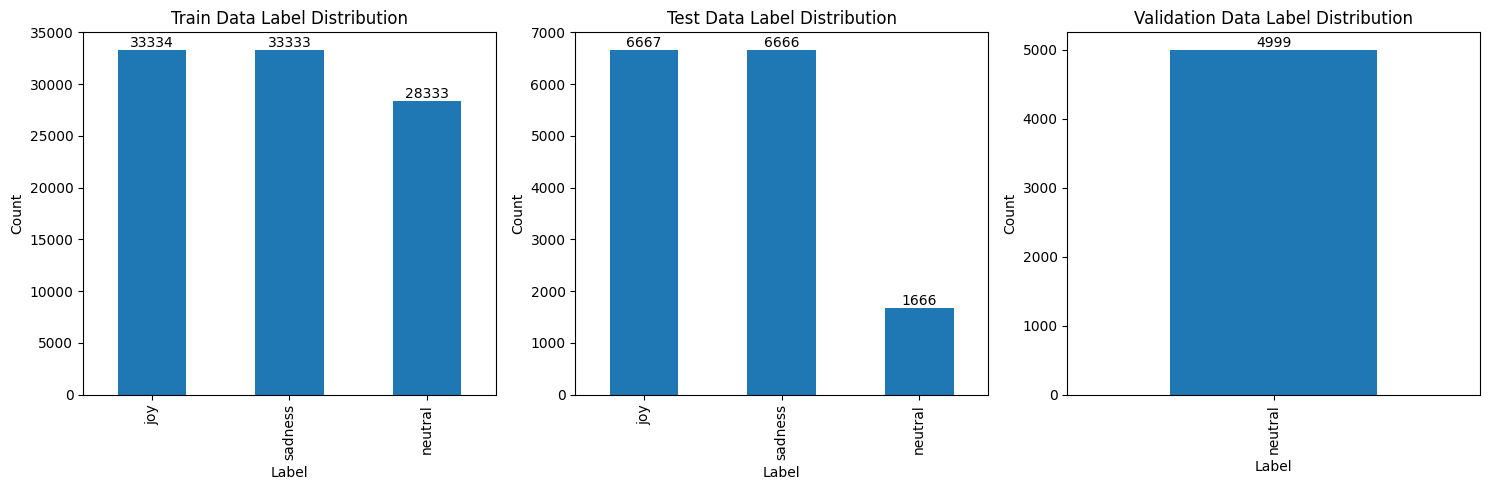

In [27]:
def plot_label_distribution(ax, data, title):
    """Plot the distribution of labels in the dataset."""
    counts = data.label.value_counts()
    counts.plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    # Add value annotations on top of the bars
    for p in ax.patches:
        ax.annotate(str(p.get_height()),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
plot_label_distribution(ax1, train_data, 'Train Data Label Distribution')
plot_label_distribution(ax2, test_data, 'Test Data Label Distribution')
plot_label_distribution(ax3, validation_data, 'Validation Data Label Distribution')
plt.tight_layout()
plt.show()

Check for word count distribution

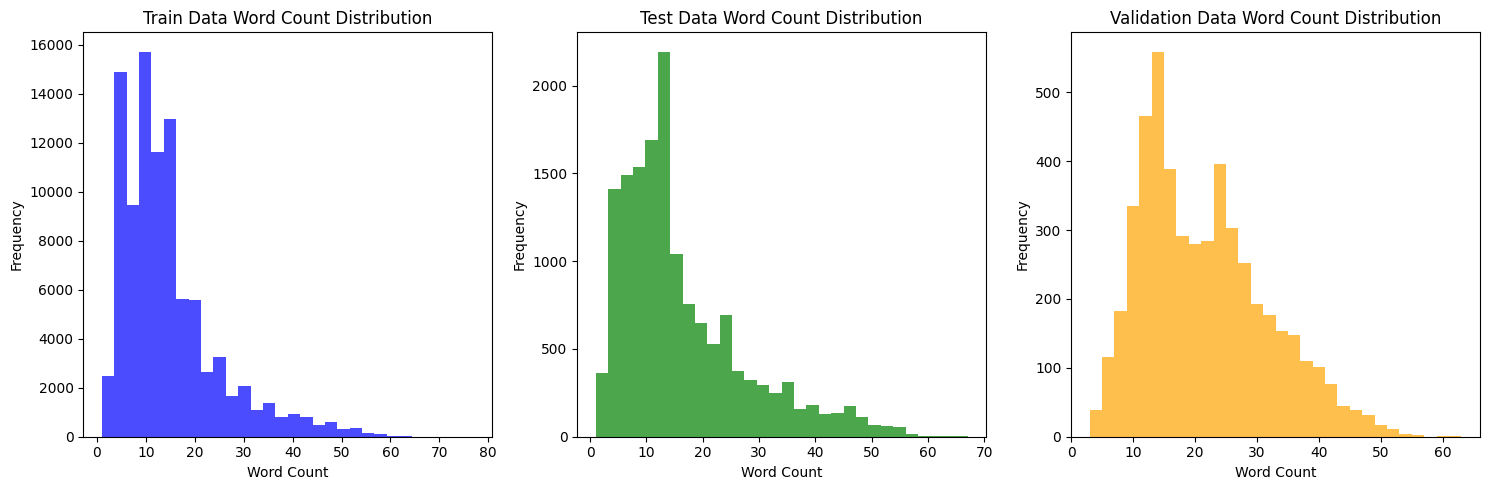

In [28]:
# Add a column for word count in each dataset
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(x.split()))
validation_data['word_count'] = validation_data['text'].apply(lambda x: len(x.split()))

# Plot the distribution of word counts
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
train_data['word_count'].plot(kind='hist', bins=30, ax=ax1, color='blue', alpha=0.7)
ax1.set_title('Train Data Word Count Distribution')
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')

test_data['word_count'].plot(kind='hist', bins=30, ax=ax2, color='green', alpha=0.7)
ax2.set_title('Test Data Word Count Distribution')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')

validation_data['word_count'].plot(kind='hist', bins=30, ax=ax3, color='orange', alpha=0.7)
ax3.set_title('Validation Data Word Count Distribution')
ax3.set_xlabel('Word Count')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Word cloud for frequencies analysis

[nltk_data] Downloading package stopwords to /home/nitro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


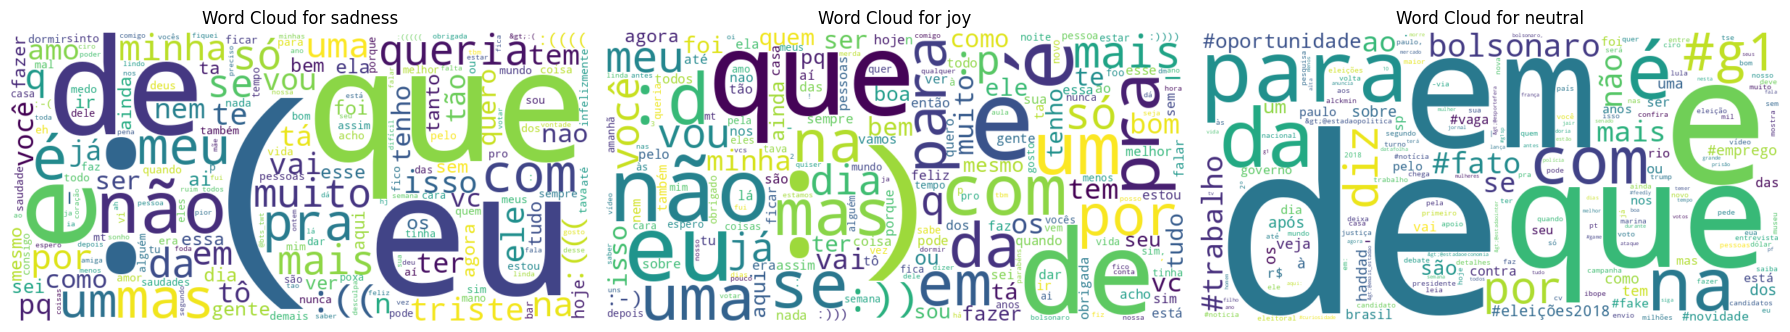

Most common words for sadness:
[(':(', 27200), ('eu', 11923), ('que', 10422), ('de', 8277), ('e', 7330), ('não', 7252), ('é', 4718), ('mas', 3916), ('com', 3656), ('meu', 3499)]

Most common words for joy:
[(':)', 22975), ('que', 11505), ('de', 11413), ('e', 10642), ('eu', 6785), ('não', 6375), ('é', 6301), ('um', 4105), (':d', 3885), ('com', 3793)]

Most common words for neutral:
[('de', 18627), ('e', 8875), ('em', 7074), ('que', 5863), ('para', 5103), ('da', 4395), ('é', 4182), ('na', 3672), ('com', 3618), ('#g1', 3511)]



In [30]:
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define a function to generate word clouds and word frequencies
def generate_word_cloud(data, label, ax):
    """Generate a word cloud for a specific label."""
    # Filter data for the given label
    subset = data[data['label'] == label]
    
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = subset['text'].str.split().explode()
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    
    # Generate word frequencies
    word_freq = Counter(filtered_words)
    
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Word Cloud for {label}")

    return word_freq

# Generate word clouds for each label
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
axes = axes.flatten()

word_frequencies = {}
for i, label in enumerate(labels.values()):
    word_frequencies[label] = generate_word_cloud(train_data, label, axes[i])

plt.tight_layout()
plt.show()

# Display the most common words for each label
for label, freq in word_frequencies.items():
    print(f"Most common words for {label}:")
    print(freq.most_common(10))
    print()

Calculate Type-Token Ration (TTR)

In [31]:
def calculate_ttr(data):
    """Calculate the Type-Token Ratio (TTR) for a dataset."""
    total_words = data['text'].str.split().explode()
    unique_words = total_words.nunique()
    total_word_count = total_words.size
    return unique_words / total_word_count

# Calculate TTR for each dataset
train_ttr = calculate_ttr(train_data)
test_ttr = calculate_ttr(test_data)
validation_ttr = calculate_ttr(validation_data)

# Print the results
print(f"Train Data TTR: {train_ttr:.4f}")
print(f"Test Data TTR: {test_ttr:.4f}")
print(f"Validation Data TTR: {validation_ttr:.4f}")

Train Data TTR: 0.1494
Test Data TTR: 0.1873
Validation Data TTR: 0.2859


Check text anomalies

In [32]:
import re

def check_anomalies(data, dataset_name):
    """Check for missing values, empty strings, and unusual characters in the dataset."""
    print(f"Checking anomalies in {dataset_name} dataset:")
    
    # Check for missing values
    missing_values = data.isnull().sum()
    print("Missing values:")
    print(missing_values)
    
    # Check for empty strings in the 'text' column
    empty_strings = (data['text'].str.strip() == '').sum()
    print(f"Empty strings in 'text' column: {empty_strings}")
    
    # Check for unusual characters in the 'text' column
    unusual_characters = data['text'].apply(lambda x: bool(re.search(r'[^a-zA-Z0-9\s.,!?\'"-]', x))).sum()
    print(f"Rows with unusual characters in 'text' column: {unusual_characters}")
    print()

# Perform checks on each dataset
check_anomalies(train_data, "Train")
check_anomalies(test_data, "Test")
check_anomalies(validation_data, "Validation")

Checking anomalies in Train dataset:
Missing values:
text          0
label         0
word_count    0
dtype: int64
Empty strings in 'text' column: 0
Rows with unusual characters in 'text' column: 95000

Checking anomalies in Test dataset:
Missing values:
text          0
label         0
word_count    0
dtype: int64
Empty strings in 'text' column: 0
Rows with unusual characters in 'text' column: 14999

Checking anomalies in Validation dataset:
Missing values:
text          0
label         0
word_count    0
dtype: int64
Empty strings in 'text' column: 0
Rows with unusual characters in 'text' column: 4999



Check sentiment readability

In [33]:
def analyze_sentiment_readability(data):
    """Analyze sentiment and readability for each label in the dataset."""
    results = []
    for label in data['label'].unique():
        subset = data[data['label'] == label].copy()  # Use .copy() to avoid SettingWithCopyWarning
        
        # Sentiment analysis
        subset.loc[:, 'polarity'] = subset['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
        subset.loc[:, 'subjectivity'] = subset['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
        
        # Readability analysis
        subset.loc[:, 'readability'] = subset['text'].apply(lambda x: textstat.flesch_reading_ease(x))
        
        # Aggregate metrics
        avg_polarity = subset['polarity'].mean()
        avg_subjectivity = subset['subjectivity'].mean()
        avg_readability = subset['readability'].mean()
        
        results.append({
            'label': label,
            'avg_polarity': avg_polarity,
            'avg_subjectivity': avg_subjectivity,
            'avg_readability': avg_readability
        })
    
    return pd.DataFrame(results)

# Perform analysis on avaiable datasets
train_sentiment_readability_results = analyze_sentiment_readability(train_data)
test_sentiment_readability_results = analyze_sentiment_readability(test_data)
validation_sentiment_readability_results = analyze_sentiment_readability(validation_data)

# Display the results
print(train_sentiment_readability_results)
print('\n')
print(test_sentiment_readability_results)
print('\n')
print(validation_sentiment_readability_results)

     label  avg_polarity  avg_subjectivity  avg_readability
0      joy      0.550842          0.976797        49.609340
1  sadness     -0.727616          0.987102        53.784623
2  neutral     -0.006440          0.059943        24.044045


     label  avg_polarity  avg_subjectivity  avg_readability
0      joy      0.455624          0.811089        43.370000
1  sadness     -0.720007          0.983674        51.148723
2  neutral     -0.001419          0.036107        21.842437


     label  avg_polarity  avg_subjectivity  avg_readability
0  neutral     -0.020642          0.112783        21.689326
